In [1]:
import os
os.chdir( "../")

In [2]:
import pandas as pd
import numpy as np
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

path = "Dataset/data_train.csv"
df = pd.read_csv(filepath_or_buffer=path,
                               sep=",",
                               header=1,
                               engine='python',
                               names=['UserID', 'ItemID', 'Interaction'])


df

,UserID,ItemID,Interaction
0,1,15,1.0
1,1,16,1.0
2,1,133,1.0
3,1,161,1.0
4,1,187,1.0
...,...,...,...
478724,13024,13605,1.0
478725,13024,13823,1.0
478726,13024,15122,1.0
478727,13024,18185,1.0


In [3]:
user_ids = df["UserID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
item_ids = df["ItemID"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}
df["User"] = df["UserID"].map(user2user_encoded)
df["Item"] = df["ItemID"].map(item2item_encoded)

num_users = len(user2user_encoded)
num_items = len(item_encoded2item)
df["Interaction"] = df["Interaction"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = 0.0
max_rating = max(df["Interaction"])

print(
    "Number of users: {}, Number of Items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)

Number of users: 12638, Number of Items: 22222, Min rating: 0.0, Max rating: 1.0


In [4]:
userId_unique = df["UserID"].unique()
itemId_unique = df["ItemID"].unique()

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
import scipy.sparse as sps


URM_all = sps.coo_matrix((df["Interaction"].values, 
                          (df["User"].values, df["Item"].values)))

URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.80)


In [6]:
num_users = len(userId_unique)
num_items = len(itemId_unique)

In [7]:
URM_all, URM_train, URM_test, URM_validation, URM_train_validation

(<12638x22222 sparse matrix of type '<class 'numpy.float32'>'
 	with 478729 stored elements in COOrdinate format>,
 <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
 	with 306386 stored elements in Compressed Sparse Row format>,
 <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
 	with 95746 stored elements in Compressed Sparse Row format>,
 <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
 	with 76597 stored elements in Compressed Sparse Row format>,
 <12638x22222 sparse matrix of type '<class 'numpy.float64'>'
 	with 382983 stored elements in Compressed Sparse Row format>)

In [8]:
from Recommenders.Recommender_import_list import *
from Evaluation.Evaluator import EvaluatorHoldout
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10], ignore_users=[])

/Users/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


EvaluatorHoldout: Ignoring 2602 (20.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users


In [76]:
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
model = ItemKNNCustomSimilarityRecommender


In [87]:
SLIMEN_best_params = {'topK': 7693, 'l1_ratio': 0.08013148517795793, 'alpha': 0.0012244028139782985}
RP3Beta_best_params = {'topK': 41,
 'alpha': 0.24025759098180052,
 'beta': 0.21463311953617964,
 'normalize_similarity': True}

slimen = SLIMElasticNetRecommender(URM_train=URM_train)
slimen.fit(**SLIMEN_best_params)

rp3 = RP3betaRecommender(URM_train=URM_train)
rp3.fit(**RP3Beta_best_params)

normalize_similarities = False

W_slimen = slimen.W_sparse
W_rp3 = rp3.W_sparse

SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 18947 (85.3%) in 5.00 min. Items per second: 63.12
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 6.07 min. Items per second: 60.99
RP3betaRecommender: URM Detected 472 ( 3.7%) users with no interactions.
RP3betaRecommender: URM Detected 341 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 4166.06 column/sec. Elapsed time 5.33 sec


In [103]:
import optuna as op



if normalize_similarities:
    mini = W_slimen.min()
    maxi = W_slimen.max()
    W_slimen = (W_slimen - mini) / (maxi-mini)

    mini = W_rp3.min()
    maxi = W_rp3.max()
    W_rp3 = (W_rp3 - mini) / (maxi-mini)


def objective(trial):

    #hyperparameters_range_dictionary = {
        #"topK": trial.suggest_int("topK",520, 590),
        #"alpha": trial.suggest_float("alpha",0.41, 0.44),
        #"topK": trial.suggest_int("topK",5, 1000),
        
        #"similarity": trial.suggest_categorical("similarity",["tversky", "dice", "jaccard", "tanimoto"]),
        #"normalize": trial.suggest_categorical("normalize",[True,False]),
    #}
    alpha = trial.suggest_float("alpha",0.1, 1)
    topK = trial.suggest_int("topK",1, 10000)
    recommender = ItemKNNCustomSimilarityRecommender(URM_train=URM_train, verbose=True)
    #recommender.fit(topK=None,**hyperparameters_range_dictionary)
    mixW = slimen.W_sparse * alpha + rp3.W_sparse * (1-alpha)
    recommender.fit(mixW, selectTopK=True, topK=topK)


    
    result, _ = evaluator_validation.evaluateRecommender(recommender)
    MAP_result = result["MAP"].item()
       
    return MAP_result

In [105]:
study = op.create_study(direction="maximize")
#study.enqueue_trial(best_params)
study.optimize(objective, n_trials=500)


[I 2023-12-19 22:35:46,591] A new study created in memory with name: no-name-1af075ed-aaee-436f-a6c2-ced6263ea931


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.26 sec. Users per second: 1383


[I 2023-12-19 22:35:56,248] Trial 0 finished with value: 0.031149979122777276 and parameters: {'alpha': 0.6934120011000107, 'topK': 3562}. Best is trial 0 with value: 0.031149979122777276.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.14 sec. Users per second: 1406


[I 2023-12-19 22:36:05,138] Trial 1 finished with value: 0.031079455231009887 and parameters: {'alpha': 0.7293994298763101, 'topK': 8110}. Best is trial 0 with value: 0.031149979122777276.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.22 sec. Users per second: 1390


[I 2023-12-19 22:36:14,233] Trial 2 finished with value: 0.03054103244193938 and parameters: {'alpha': 0.9545125035193417, 'topK': 5924}. Best is trial 0 with value: 0.031149979122777276.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.95 sec. Users per second: 1444


[I 2023-12-19 22:36:22,942] Trial 3 finished with value: 0.03139960428172884 and parameters: {'alpha': 0.5205028219503337, 'topK': 9958}. Best is trial 3 with value: 0.03139960428172884.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.65 sec. Users per second: 1311


[I 2023-12-19 22:36:32,362] Trial 4 finished with value: 0.031233582911044288 and parameters: {'alpha': 0.5895094006751516, 'topK': 1483}. Best is trial 3 with value: 0.03139960428172884.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.57 sec. Users per second: 1171


[I 2023-12-19 22:36:42,825] Trial 5 finished with value: 0.030822993572346212 and parameters: {'alpha': 0.8406687282529716, 'topK': 6346}. Best is trial 3 with value: 0.03139960428172884.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.20 sec. Users per second: 1224


[I 2023-12-19 22:36:53,065] Trial 6 finished with value: 0.03049931358221538 and parameters: {'alpha': 0.9843363324790099, 'topK': 3645}. Best is trial 3 with value: 0.03139960428172884.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.81 sec. Users per second: 1286


[I 2023-12-19 22:37:03,067] Trial 7 finished with value: 0.03095064118380213 and parameters: {'alpha': 0.8207236722945406, 'topK': 663}. Best is trial 3 with value: 0.03139960428172884.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.40 sec. Users per second: 1195


[I 2023-12-19 22:37:13,544] Trial 8 finished with value: 0.030665663136518334 and parameters: {'alpha': 0.8926812622159885, 'topK': 7852}. Best is trial 3 with value: 0.03139960428172884.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.20 sec. Users per second: 1223


[I 2023-12-19 22:37:23,693] Trial 9 finished with value: 0.031392063966546105 and parameters: {'alpha': 0.3505296716275732, 'topK': 1876}. Best is trial 3 with value: 0.03139960428172884.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.37 sec. Users per second: 1200


[I 2023-12-19 22:37:34,152] Trial 10 finished with value: 0.030636387576154677 and parameters: {'alpha': 0.10591363981843954, 'topK': 9932}. Best is trial 3 with value: 0.03139960428172884.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.60 sec. Users per second: 1320


[I 2023-12-19 22:37:43,901] Trial 11 finished with value: 0.031446736194145765 and parameters: {'alpha': 0.3972283724792597, 'topK': 2858}. Best is trial 11 with value: 0.031446736194145765.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.30 sec. Users per second: 1376


[I 2023-12-19 22:37:53,017] Trial 12 finished with value: 0.03148946728286127 and parameters: {'alpha': 0.42564519505518444, 'topK': 3665}. Best is trial 12 with value: 0.03148946728286127.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.12 sec. Users per second: 1410


[I 2023-12-19 22:38:01,847] Trial 13 finished with value: 0.031493808796270145 and parameters: {'alpha': 0.4090058137060839, 'topK': 3613}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.13 sec. Users per second: 1408


[I 2023-12-19 22:38:10,980] Trial 14 finished with value: 0.03143239496542632 and parameters: {'alpha': 0.34062970991880914, 'topK': 4558}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.23 sec. Users per second: 1388


[I 2023-12-19 22:38:20,020] Trial 15 finished with value: 0.03135846270885151 and parameters: {'alpha': 0.4920242074561675, 'topK': 4985}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.51 sec. Users per second: 1337


[I 2023-12-19 22:38:29,852] Trial 16 finished with value: 0.03132704011590054 and parameters: {'alpha': 0.2574788476888028, 'topK': 2458}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.88 sec. Users per second: 1459


[I 2023-12-19 22:38:38,522] Trial 17 finished with value: 0.03125359815774339 and parameters: {'alpha': 0.6204346308660533, 'topK': 558}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.96 sec. Users per second: 1442


[I 2023-12-19 22:38:47,349] Trial 18 finished with value: 0.03143921169504092 and parameters: {'alpha': 0.465165483242142, 'topK': 3746}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.99 sec. Users per second: 1435


[I 2023-12-19 22:38:56,102] Trial 19 finished with value: 0.031333327006902445 and parameters: {'alpha': 0.26280791828121475, 'topK': 5500}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.13 sec. Users per second: 1407


[I 2023-12-19 22:39:04,986] Trial 20 finished with value: 0.03145152055773839 and parameters: {'alpha': 0.45907274601272424, 'topK': 6992}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.92 sec. Users per second: 1126


[I 2023-12-19 22:39:15,643] Trial 21 finished with value: 0.03148401864399295 and parameters: {'alpha': 0.44491373152531744, 'topK': 6825}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.91 sec. Users per second: 1453


[I 2023-12-19 22:39:24,489] Trial 22 finished with value: 0.03125681672961489 and parameters: {'alpha': 0.5804435717158158, 'topK': 6989}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.94 sec. Users per second: 1447


[I 2023-12-19 22:39:33,128] Trial 23 finished with value: 0.03146418528219068 and parameters: {'alpha': 0.43325365480942135, 'topK': 4453}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.30 sec. Users per second: 1209


[I 2023-12-19 22:39:43,235] Trial 24 finished with value: 0.031365093599549775 and parameters: {'alpha': 0.5337625245540855, 'topK': 8449}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.22 sec. Users per second: 1390


[I 2023-12-19 22:39:52,409] Trial 25 finished with value: 0.03144881996242124 and parameters: {'alpha': 0.40198919039631087, 'topK': 2951}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.72 sec. Users per second: 1151


[I 2023-12-19 22:40:03,075] Trial 26 finished with value: 0.0313637848190959 and parameters: {'alpha': 0.5281596246861096, 'topK': 4353}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.82 sec. Users per second: 1283


[I 2023-12-19 22:40:12,803] Trial 27 finished with value: 0.031236916149481125 and parameters: {'alpha': 0.6400755336505928, 'topK': 5262}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.48 sec. Users per second: 1342


[I 2023-12-19 22:40:22,026] Trial 28 finished with value: 0.031416219071659764 and parameters: {'alpha': 0.33454879570201285, 'topK': 6289}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.77 sec. Users per second: 1291


[I 2023-12-19 22:40:31,670] Trial 29 finished with value: 0.03135552487236446 and parameters: {'alpha': 0.4878323267008454, 'topK': 1924}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.82 sec. Users per second: 1138


[I 2023-12-19 22:40:42,356] Trial 30 finished with value: 0.031200788273327333 and parameters: {'alpha': 0.6685193255520268, 'topK': 8922}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.42 sec. Users per second: 1352


[I 2023-12-19 22:40:52,118] Trial 31 finished with value: 0.03148278498990957 and parameters: {'alpha': 0.4220111618980321, 'topK': 4201}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.43 sec. Users per second: 1350


[I 2023-12-19 22:41:01,297] Trial 32 finished with value: 0.031320314328734264 and parameters: {'alpha': 0.5543709089715053, 'topK': 3394}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.14 sec. Users per second: 1407


[I 2023-12-19 22:41:10,288] Trial 33 finished with value: 0.03145082860432627 and parameters: {'alpha': 0.39501619971611673, 'topK': 4073}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.50 sec. Users per second: 1338


[I 2023-12-19 22:41:19,747] Trial 34 finished with value: 0.03148977174236262 and parameters: {'alpha': 0.4429712462672064, 'topK': 4792}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 11.21 sec. Users per second: 895


[I 2023-12-19 22:41:32,879] Trial 35 finished with value: 0.031417939070141336 and parameters: {'alpha': 0.47427535546458965, 'topK': 5751}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 9.69 sec. Users per second: 1036


[I 2023-12-19 22:41:45,536] Trial 36 finished with value: 0.031110545686323116 and parameters: {'alpha': 0.7215256521520107, 'topK': 4871}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 9.72 sec. Users per second: 1032


[I 2023-12-19 22:41:57,237] Trial 37 finished with value: 0.03123422346220298 and parameters: {'alpha': 0.5897725295190043, 'topK': 7077}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.26 sec. Users per second: 1383


[I 2023-12-19 22:42:06,329] Trial 38 finished with value: 0.03138217100976187 and parameters: {'alpha': 0.5399569434389436, 'topK': 3302}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.79 sec. Users per second: 1289


[I 2023-12-19 22:42:15,920] Trial 39 finished with value: 0.03135282823106679 and parameters: {'alpha': 0.4955601621635457, 'topK': 6364}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 9.09 sec. Users per second: 1104


[I 2023-12-19 22:42:27,500] Trial 40 finished with value: 0.0314679811409088 and parameters: {'alpha': 0.43812858941404403, 'topK': 2791}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.99 sec. Users per second: 1256


[I 2023-12-19 22:42:37,443] Trial 41 finished with value: 0.03147107318415631 and parameters: {'alpha': 0.4036481306408537, 'topK': 3968}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 9.25 sec. Users per second: 1085


[I 2023-12-19 22:42:48,766] Trial 42 finished with value: 0.031408180550020204 and parameters: {'alpha': 0.36112029471222984, 'topK': 4889}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.75 sec. Users per second: 1296


[I 2023-12-19 22:42:58,631] Trial 43 finished with value: 0.0314557553126208 and parameters: {'alpha': 0.437230502807301, 'topK': 5910}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 11.25 sec. Users per second: 892


[I 2023-12-19 22:43:11,812] Trial 44 finished with value: 0.0314029414741852 and parameters: {'alpha': 0.5081003284979032, 'topK': 2335}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.73 sec. Users per second: 1150


[I 2023-12-19 22:43:22,881] Trial 45 finished with value: 0.031410493651426584 and parameters: {'alpha': 0.30478816456790064, 'topK': 1308}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.41 sec. Users per second: 1193


[I 2023-12-19 22:43:33,374] Trial 46 finished with value: 0.03144900580133766 and parameters: {'alpha': 0.3777246305257892, 'topK': 4126}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.23 sec. Users per second: 1220


[I 2023-12-19 22:43:43,569] Trial 47 finished with value: 0.031479056349522874 and parameters: {'alpha': 0.42882350943203484, 'topK': 3176}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.63 sec. Users per second: 1163


[I 2023-12-19 22:43:54,502] Trial 48 finished with value: 0.03144774051509834 and parameters: {'alpha': 0.30917548007596574, 'topK': 3661}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 9.10 sec. Users per second: 1103


[I 2023-12-19 22:44:05,640] Trial 49 finished with value: 0.031478411844344696 and parameters: {'alpha': 0.46051124645556296, 'topK': 5311}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 10.27 sec. Users per second: 977


[I 2023-12-19 22:44:18,710] Trial 50 finished with value: 0.03140930744557715 and parameters: {'alpha': 0.3702339199742651, 'topK': 7727}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.99 sec. Users per second: 1116


[I 2023-12-19 22:44:29,794] Trial 51 finished with value: 0.03148946728286127 and parameters: {'alpha': 0.42562736712728494, 'topK': 3226}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.86 sec. Users per second: 1133


[I 2023-12-19 22:44:40,822] Trial 52 finished with value: 0.03148578609070859 and parameters: {'alpha': 0.40730686783736175, 'topK': 4609}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.80 sec. Users per second: 1286


[I 2023-12-19 22:44:50,586] Trial 53 finished with value: 0.03135576606755384 and parameters: {'alpha': 0.49132214080782216, 'topK': 4542}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.51 sec. Users per second: 1179


[I 2023-12-19 22:45:01,060] Trial 54 finished with value: 0.03144250539328281 and parameters: {'alpha': 0.45519938469859544, 'topK': 2229}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.51 sec. Users per second: 1179


[I 2023-12-19 22:45:11,560] Trial 55 finished with value: 0.03144286520905717 and parameters: {'alpha': 0.38290332578887926, 'topK': 1299}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.53 sec. Users per second: 1333


[I 2023-12-19 22:45:21,186] Trial 56 finished with value: 0.03143723468529195 and parameters: {'alpha': 0.3403949311703199, 'topK': 2673}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.93 sec. Users per second: 1448


[I 2023-12-19 22:45:29,877] Trial 57 finished with value: 0.031483516483516695 and parameters: {'alpha': 0.4107282116024374, 'topK': 3778}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.94 sec. Users per second: 1446


[I 2023-12-19 22:45:38,593] Trial 58 finished with value: 0.03140147848697093 and parameters: {'alpha': 0.5103908043439287, 'topK': 4721}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.92 sec. Users per second: 1451


[I 2023-12-19 22:45:47,289] Trial 59 finished with value: 0.03131297962256535 and parameters: {'alpha': 0.5555887778928599, 'topK': 3075}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.96 sec. Users per second: 1442


[I 2023-12-19 22:45:56,016] Trial 60 finished with value: 0.03145418556688009 and parameters: {'alpha': 0.4575279118911454, 'topK': 5138}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.86 sec. Users per second: 1463


[I 2023-12-19 22:46:04,694] Trial 61 finished with value: 0.031481776714937564 and parameters: {'alpha': 0.41271981557275594, 'topK': 3657}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 5.47 sec. Users per second: 1836


[I 2023-12-19 22:46:11,173] Trial 62 finished with value: 0.03063634803595972 and parameters: {'alpha': 0.4052155338010316, 'topK': 20}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.84 sec. Users per second: 1468


[I 2023-12-19 22:46:19,770] Trial 63 finished with value: 0.031384199421764444 and parameters: {'alpha': 0.35554832514305, 'topK': 3763}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.84 sec. Users per second: 1468


[I 2023-12-19 22:46:28,367] Trial 64 finished with value: 0.031400039223873626 and parameters: {'alpha': 0.4774385601255774, 'topK': 3392}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.91 sec. Users per second: 1453


[I 2023-12-19 22:46:37,123] Trial 65 finished with value: 0.031454193474919075 and parameters: {'alpha': 0.43687610883182854, 'topK': 5541}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.47 sec. Users per second: 1343


[I 2023-12-19 22:46:46,453] Trial 66 finished with value: 0.03140918882499215 and parameters: {'alpha': 0.513035254469384, 'topK': 4326}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.63 sec. Users per second: 1316


[I 2023-12-19 22:46:56,042] Trial 67 finished with value: 0.031415701095105504 and parameters: {'alpha': 0.3858456235733017, 'topK': 3901}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.32 sec. Users per second: 1371


[I 2023-12-19 22:47:05,266] Trial 68 finished with value: 0.03143672461677673 and parameters: {'alpha': 0.3196932654484948, 'topK': 6570}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.73 sec. Users per second: 1490


[I 2023-12-19 22:47:13,728] Trial 69 finished with value: 0.03141659074949259 and parameters: {'alpha': 0.28902596611333864, 'topK': 9286}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.19 sec. Users per second: 1396


[I 2023-12-19 22:47:22,724] Trial 70 finished with value: 0.0314079788950258 and parameters: {'alpha': 0.36998938406479254, 'topK': 4630}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.02 sec. Users per second: 1429


[I 2023-12-19 22:47:31,483] Trial 71 finished with value: 0.031483425541068255 and parameters: {'alpha': 0.4187078405259096, 'topK': 4223}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.14 sec. Users per second: 1405


[I 2023-12-19 22:47:40,428] Trial 72 finished with value: 0.031493630865392724 and parameters: {'alpha': 0.4276907558210553, 'topK': 3468}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.31 sec. Users per second: 1372


[I 2023-12-19 22:47:49,686] Trial 73 finished with value: 0.031490072247844475 and parameters: {'alpha': 0.44402942071060375, 'topK': 2624}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.57 sec. Users per second: 1325


[I 2023-12-19 22:47:59,164] Trial 74 finished with value: 0.03139119803627595 and parameters: {'alpha': 0.47814543431615236, 'topK': 2042}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.97 sec. Users per second: 1441


[I 2023-12-19 22:48:07,894] Trial 75 finished with value: 0.031469626013020016 and parameters: {'alpha': 0.447751074784336, 'topK': 2560}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.91 sec. Users per second: 1453


[I 2023-12-19 22:48:16,531] Trial 76 finished with value: 0.031407251355438155 and parameters: {'alpha': 0.34552188453790855, 'topK': 1725}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.88 sec. Users per second: 1458


[I 2023-12-19 22:48:25,170] Trial 77 finished with value: 0.03142061198732203 and parameters: {'alpha': 0.4716872816240891, 'topK': 3011}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.07 sec. Users per second: 1420


[I 2023-12-19 22:48:33,999] Trial 78 finished with value: 0.03137245598385516 and parameters: {'alpha': 0.5246925090981021, 'topK': 3463}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.15 sec. Users per second: 1403


[I 2023-12-19 22:48:42,985] Trial 79 finished with value: 0.03149072466106166 and parameters: {'alpha': 0.4444359406513718, 'topK': 2825}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.88 sec. Users per second: 1460


[I 2023-12-19 22:48:51,634] Trial 80 finished with value: 0.0314132654190947 and parameters: {'alpha': 0.3859504321101608, 'topK': 2824}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.83 sec. Users per second: 1470


[I 2023-12-19 22:49:00,244] Trial 81 finished with value: 0.03146167052578991 and parameters: {'alpha': 0.4338149878621365, 'topK': 3134}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.83 sec. Users per second: 1470


[I 2023-12-19 22:49:08,813] Trial 82 finished with value: 0.03146347751270053 and parameters: {'alpha': 0.4496657114706845, 'topK': 2534}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.47 sec. Users per second: 1552


[I 2023-12-19 22:49:17,022] Trial 83 finished with value: 0.031356216825776634 and parameters: {'alpha': 0.49476777994961285, 'topK': 3463}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.83 sec. Users per second: 1469


[I 2023-12-19 22:49:25,608] Trial 84 finished with value: 0.03148971243207017 and parameters: {'alpha': 0.4164510381293071, 'topK': 2220}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.14 sec. Users per second: 1406


[I 2023-12-19 22:49:34,511] Trial 85 finished with value: 0.03146409829376173 and parameters: {'alpha': 0.40352958875990796, 'topK': 2136}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.41 sec. Users per second: 1355


[I 2023-12-19 22:49:43,760] Trial 86 finished with value: 0.0314075874470955 and parameters: {'alpha': 0.3611935107769211, 'topK': 1706}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.18 sec. Users per second: 1398


[I 2023-12-19 22:49:52,738] Trial 87 finished with value: 0.031485240436017865 and parameters: {'alpha': 0.4194361758755559, 'topK': 2404}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.40 sec. Users per second: 1195


[I 2023-12-19 22:50:03,058] Trial 88 finished with value: 0.031430908254095044 and parameters: {'alpha': 0.39002623399350755, 'topK': 4033}. Best is trial 13 with value: 0.031493808796270145.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.76 sec. Users per second: 1294


[I 2023-12-19 22:50:12,693] Trial 89 finished with value: 0.03149824520614696 and parameters: {'alpha': 0.42656850964804516, 'topK': 2805}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.33 sec. Users per second: 1205


[I 2023-12-19 22:50:22,892] Trial 90 finished with value: 0.03139733862855645 and parameters: {'alpha': 0.4792328525007194, 'topK': 2889}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.64 sec. Users per second: 1313


[I 2023-12-19 22:50:32,526] Trial 91 finished with value: 0.03147695676516941 and parameters: {'alpha': 0.46097847231339606, 'topK': 3301}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.36 sec. Users per second: 1364


[I 2023-12-19 22:50:41,911] Trial 92 finished with value: 0.03147890214276247 and parameters: {'alpha': 0.41852127075990936, 'topK': 2637}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 9.04 sec. Users per second: 1110


[I 2023-12-19 22:50:54,543] Trial 93 finished with value: 0.03146588551057483 and parameters: {'alpha': 0.43997056791293276, 'topK': 1465}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.07 sec. Users per second: 1244


[I 2023-12-19 22:51:05,044] Trial 94 finished with value: 0.03143050889812572 and parameters: {'alpha': 0.3762778247453942, 'topK': 3203}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.34 sec. Users per second: 1368


[I 2023-12-19 22:51:14,234] Trial 95 finished with value: 0.0314519396838052 and parameters: {'alpha': 0.39909327398721567, 'topK': 1075}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.58 sec. Users per second: 1324


[I 2023-12-19 22:51:23,626] Trial 96 finished with value: 0.03135721719270963 and parameters: {'alpha': 0.49420749860132246, 'topK': 2247}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.46 sec. Users per second: 1345


[I 2023-12-19 22:51:33,002] Trial 97 finished with value: 0.03145553784154841 and parameters: {'alpha': 0.4576080071979073, 'topK': 2888}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.92 sec. Users per second: 1267


[I 2023-12-19 22:51:42,767] Trial 98 finished with value: 0.03144289684121318 and parameters: {'alpha': 0.3320174782119651, 'topK': 3568}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.33 sec. Users per second: 1369


[I 2023-12-19 22:51:52,038] Trial 99 finished with value: 0.03148000531420241 and parameters: {'alpha': 0.43166886108337404, 'topK': 1934}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.21 sec. Users per second: 1392


[I 2023-12-19 22:52:00,954] Trial 100 finished with value: 0.0313784067831998 and parameters: {'alpha': 0.35459182659187205, 'topK': 4434}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.36 sec. Users per second: 1364


[I 2023-12-19 22:52:10,040] Trial 101 finished with value: 0.03149348852069081 and parameters: {'alpha': 0.41481625547366935, 'topK': 2414}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.20 sec. Users per second: 1394


[I 2023-12-19 22:52:19,136] Trial 102 finished with value: 0.03145238253398899 and parameters: {'alpha': 0.39867242422905014, 'topK': 2381}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.52 sec. Users per second: 1335


[I 2023-12-19 22:52:28,359] Trial 103 finished with value: 0.031481887427483514 and parameters: {'alpha': 0.4224902272633256, 'topK': 3853}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.85 sec. Users per second: 1279


[I 2023-12-19 22:52:38,014] Trial 104 finished with value: 0.03142061198732203 and parameters: {'alpha': 0.47164408893282933, 'topK': 2783}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.35 sec. Users per second: 1365


[I 2023-12-19 22:52:47,224] Trial 105 finished with value: 0.031448396882334945 and parameters: {'alpha': 0.379108896372804, 'topK': 3072}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.03 sec. Users per second: 1250


[I 2023-12-19 22:52:57,057] Trial 106 finished with value: 0.03145408276237314 and parameters: {'alpha': 0.4519804335161339, 'topK': 4822}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.91 sec. Users per second: 1453


[I 2023-12-19 22:53:06,440] Trial 107 finished with value: 0.03142337584695124 and parameters: {'alpha': 0.36738239054257865, 'topK': 2658}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.16 sec. Users per second: 1401


[I 2023-12-19 22:53:15,469] Trial 108 finished with value: 0.03148266241530514 and parameters: {'alpha': 0.4134585913166539, 'topK': 5044}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.81 sec. Users per second: 1473


[I 2023-12-19 22:53:24,137] Trial 109 finished with value: 0.031410766478771876 and parameters: {'alpha': 0.5130423534408151, 'topK': 1767}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.81 sec. Users per second: 1474


[I 2023-12-19 22:53:32,778] Trial 110 finished with value: 0.0314671863829897 and parameters: {'alpha': 0.4393254449507979, 'topK': 3294}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.24 sec. Users per second: 1387


[I 2023-12-19 22:53:41,748] Trial 111 finished with value: 0.031484410091923265 and parameters: {'alpha': 0.42374394825290346, 'topK': 2462}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.50 sec. Users per second: 1339


[I 2023-12-19 22:53:51,162] Trial 112 finished with value: 0.03144612332112357 and parameters: {'alpha': 0.39716497474585427, 'topK': 2143}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.99 sec. Users per second: 1436


[I 2023-12-19 22:54:00,078] Trial 113 finished with value: 0.03147744310956769 and parameters: {'alpha': 0.42276453111569723, 'topK': 2415}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.61 sec. Users per second: 1318


[I 2023-12-19 22:54:09,498] Trial 114 finished with value: 0.03143344673461274 and parameters: {'alpha': 0.4670232533219352, 'topK': 3614}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.94 sec. Users per second: 1446


[I 2023-12-19 22:54:18,692] Trial 115 finished with value: 0.03136041204046407 and parameters: {'alpha': 0.48812469498923616, 'topK': 4086}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.43 sec. Users per second: 1350


[I 2023-12-19 22:54:27,887] Trial 116 finished with value: 0.03146681075113739 and parameters: {'alpha': 0.44539303224944116, 'topK': 2995}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.26 sec. Users per second: 1215


[I 2023-12-19 22:54:37,945] Trial 117 finished with value: 0.031486948572441026 and parameters: {'alpha': 0.4071290610169431, 'topK': 2698}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.68 sec. Users per second: 1306


[I 2023-12-19 22:54:47,572] Trial 118 finished with value: 0.03142338770900974 and parameters: {'alpha': 0.3873604832136437, 'topK': 2754}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.74 sec. Users per second: 1488


[I 2023-12-19 22:54:56,231] Trial 119 finished with value: 0.03140558275920996 and parameters: {'alpha': 0.3442963351383732, 'topK': 5384}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.46 sec. Users per second: 1346


[I 2023-12-19 22:55:05,525] Trial 120 finished with value: 0.03149475776094968 and parameters: {'alpha': 0.40785645548942795, 'topK': 1941}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.56 sec. Users per second: 1327


[I 2023-12-19 22:55:15,224] Trial 121 finished with value: 0.03148222747316033 and parameters: {'alpha': 0.40642648324580494, 'topK': 2063}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.56 sec. Users per second: 1328


[I 2023-12-19 22:55:24,669] Trial 122 finished with value: 0.03141536500344819 and parameters: {'alpha': 0.361899608808235, 'topK': 953}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.40 sec. Users per second: 1356


[I 2023-12-19 22:55:33,833] Trial 123 finished with value: 0.031458519172249955 and parameters: {'alpha': 0.44935288215281816, 'topK': 1575}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.41 sec. Users per second: 1355


[I 2023-12-19 22:55:43,090] Trial 124 finished with value: 0.031416377232439674 and parameters: {'alpha': 0.386688596205865, 'topK': 1948}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.46 sec. Users per second: 1346


[I 2023-12-19 22:55:52,407] Trial 125 finished with value: 0.03149243279748482 and parameters: {'alpha': 0.4077313555493512, 'topK': 3189}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.52 sec. Users per second: 1334


[I 2023-12-19 22:56:02,119] Trial 126 finished with value: 0.03146333516799858 and parameters: {'alpha': 0.43433992726676246, 'topK': 3256}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.84 sec. Users per second: 1467


[I 2023-12-19 22:56:10,855] Trial 127 finished with value: 0.03144203091094303 and parameters: {'alpha': 0.4682546194765972, 'topK': 2607}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.13 sec. Users per second: 1407


[I 2023-12-19 22:56:19,818] Trial 128 finished with value: 0.03142122090632481 and parameters: {'alpha': 0.36764883460487746, 'topK': 2945}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.10 sec. Users per second: 1240


[I 2023-12-19 22:56:29,724] Trial 129 finished with value: 0.031387453579811285 and parameters: {'alpha': 0.5037088593296188, 'topK': 3390}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.36 sec. Users per second: 1201


[I 2023-12-19 22:56:40,110] Trial 130 finished with value: 0.031494125117829994 and parameters: {'alpha': 0.41499248695659713, 'topK': 2277}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.07 sec. Users per second: 1243


[I 2023-12-19 22:56:50,186] Trial 131 finished with value: 0.0314788546945285 and parameters: {'alpha': 0.40596101964739956, 'topK': 2233}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.84 sec. Users per second: 1467


[I 2023-12-19 22:56:58,860] Trial 132 finished with value: 0.03148847086994776 and parameters: {'alpha': 0.4252693753684196, 'topK': 3114}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.48 sec. Users per second: 1342


[I 2023-12-19 22:57:08,218] Trial 133 finished with value: 0.03147952687784313 and parameters: {'alpha': 0.4297723181754155, 'topK': 3134}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.43 sec. Users per second: 1351


[I 2023-12-19 22:57:17,510] Trial 134 finished with value: 0.0313597082249934 and parameters: {'alpha': 0.4830799609761794, 'topK': 3545}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.05 sec. Users per second: 1424


[I 2023-12-19 22:57:26,385] Trial 135 finished with value: 0.031451943637824685 and parameters: {'alpha': 0.4541850425704605, 'topK': 3764}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.48 sec. Users per second: 1342


[I 2023-12-19 22:57:35,794] Trial 136 finished with value: 0.03145147706352394 and parameters: {'alpha': 0.3800922894186738, 'topK': 2399}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.48 sec. Users per second: 1341


[I 2023-12-19 22:57:45,387] Trial 137 finished with value: 0.03148093846280398 and parameters: {'alpha': 0.4225430712400207, 'topK': 2993}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.25 sec. Users per second: 1217


[I 2023-12-19 22:57:55,597] Trial 138 finished with value: 0.03148526811415433 and parameters: {'alpha': 0.44215220510195324, 'topK': 1899}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.82 sec. Users per second: 1470


[I 2023-12-19 22:58:04,187] Trial 139 finished with value: 0.031440904015386094 and parameters: {'alpha': 0.46550870118876747, 'topK': 3931}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.51 sec. Users per second: 1336


[I 2023-12-19 22:58:13,556] Trial 140 finished with value: 0.031446716424048296 and parameters: {'alpha': 0.39131740179907043, 'topK': 1539}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.23 sec. Users per second: 1389


[I 2023-12-19 22:58:22,529] Trial 141 finished with value: 0.03145516220969613 and parameters: {'alpha': 0.4025878330852078, 'topK': 2708}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.64 sec. Users per second: 1313


[I 2023-12-19 22:58:32,005] Trial 142 finished with value: 0.03149348852069081 and parameters: {'alpha': 0.41481618322401753, 'topK': 2572}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.22 sec. Users per second: 1390


[I 2023-12-19 22:58:41,167] Trial 143 finished with value: 0.031481488071514206 and parameters: {'alpha': 0.4223407673178334, 'topK': 2499}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.28 sec. Users per second: 1378


[I 2023-12-19 22:58:50,513] Trial 144 finished with value: 0.031480199061157815 and parameters: {'alpha': 0.4411178265901526, 'topK': 2179}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.04 sec. Users per second: 1248


[I 2023-12-19 22:59:00,302] Trial 145 finished with value: 0.031389972290231626 and parameters: {'alpha': 0.3522891909854309, 'topK': 3167}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.03 sec. Users per second: 1428


[I 2023-12-19 22:59:09,524] Trial 146 finished with value: 0.03144709600992009 and parameters: {'alpha': 0.38061377394038715, 'topK': 2848}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.77 sec. Users per second: 1291


[I 2023-12-19 22:59:19,564] Trial 147 finished with value: 0.03142933850835435 and parameters: {'alpha': 0.3261035829495352, 'topK': 3427}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.00 sec. Users per second: 1434


[I 2023-12-19 22:59:28,359] Trial 148 finished with value: 0.031393309482687926 and parameters: {'alpha': 0.48049523222619694, 'topK': 2296}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.18 sec. Users per second: 1397


[I 2023-12-19 22:59:37,507] Trial 149 finished with value: 0.03149029367293636 and parameters: {'alpha': 0.4251551036559114, 'topK': 2589}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.49 sec. Users per second: 1340


[I 2023-12-19 22:59:46,730] Trial 150 finished with value: 0.031452975636913676 and parameters: {'alpha': 0.4573124217149618, 'topK': 1770}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.19 sec. Users per second: 1396


[I 2023-12-19 22:59:55,686] Trial 151 finished with value: 0.03149070884498368 and parameters: {'alpha': 0.41631171212681056, 'topK': 2540}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.97 sec. Users per second: 1440


[I 2023-12-19 23:00:04,690] Trial 152 finished with value: 0.03149610608159852 and parameters: {'alpha': 0.4095374804417359, 'topK': 2461}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.37 sec. Users per second: 1363


[I 2023-12-19 23:00:13,852] Trial 153 finished with value: 0.03147753800603564 and parameters: {'alpha': 0.4055817480314771, 'topK': 2626}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.87 sec. Users per second: 1275


[I 2023-12-19 23:00:23,664] Trial 154 finished with value: 0.03141615976136729 and parameters: {'alpha': 0.3689357776655828, 'topK': 2017}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.62 sec. Users per second: 1316


[I 2023-12-19 23:00:33,182] Trial 155 finished with value: 0.03148246866834972 and parameters: {'alpha': 0.4171459352866182, 'topK': 2443}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.74 sec. Users per second: 1297


[I 2023-12-19 23:00:42,914] Trial 156 finished with value: 0.03145503568107221 and parameters: {'alpha': 0.39179695619229593, 'topK': 2200}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.52 sec. Users per second: 1335


[I 2023-12-19 23:00:52,280] Trial 157 finished with value: 0.031466877969468864 and parameters: {'alpha': 0.4463155349777679, 'topK': 2826}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.91 sec. Users per second: 1452


[I 2023-12-19 23:01:00,979] Trial 158 finished with value: 0.03145498427881868 and parameters: {'alpha': 0.4349212070863053, 'topK': 1332}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.81 sec. Users per second: 1475


[I 2023-12-19 23:01:09,577] Trial 159 finished with value: 0.031398188742748585 and parameters: {'alpha': 0.34712905302041785, 'topK': 2342}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.02 sec. Users per second: 1431


[I 2023-12-19 23:01:18,361] Trial 160 finished with value: 0.031488407605635794 and parameters: {'alpha': 0.4106347208512526, 'topK': 2541}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.70 sec. Users per second: 1498


[I 2023-12-19 23:01:26,795] Trial 161 finished with value: 0.03144923908848803 and parameters: {'alpha': 0.3975553395997224, 'topK': 2933}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.46 sec. Users per second: 1345


[I 2023-12-19 23:01:36,025] Trial 162 finished with value: 0.03146373056994839 and parameters: {'alpha': 0.4631161000250711, 'topK': 2727}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.98 sec. Users per second: 1257


[I 2023-12-19 23:01:45,953] Trial 163 finished with value: 0.031475173502375775 and parameters: {'alpha': 0.4314053193234673, 'topK': 3271}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.53 sec. Users per second: 1332


[I 2023-12-19 23:01:55,407] Trial 164 finished with value: 0.03144794612411217 and parameters: {'alpha': 0.37844516297300207, 'topK': 1934}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.92 sec. Users per second: 1267


[I 2023-12-19 23:02:05,238] Trial 165 finished with value: 0.03149632750669041 and parameters: {'alpha': 0.40935353620773124, 'topK': 2557}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.72 sec. Users per second: 1493


[I 2023-12-19 23:02:13,786] Trial 166 finished with value: 0.031486228940892376 and parameters: {'alpha': 0.41424215883868065, 'topK': 2105}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.72 sec. Users per second: 1492


[I 2023-12-19 23:02:22,365] Trial 167 finished with value: 0.03144845223860795 and parameters: {'alpha': 0.3911480432721928, 'topK': 2532}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.57 sec. Users per second: 1326


[I 2023-12-19 23:02:31,709] Trial 168 finished with value: 0.03148526811415433 and parameters: {'alpha': 0.44214976179358284, 'topK': 2362}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.93 sec. Users per second: 1266


[I 2023-12-19 23:02:41,453] Trial 169 finished with value: 0.031355014803849224 and parameters: {'alpha': 0.49518642233193905, 'topK': 2941}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.41 sec. Users per second: 1355


[I 2023-12-19 23:02:50,876] Trial 170 finished with value: 0.031415546888345094 and parameters: {'alpha': 0.36886135705271506, 'topK': 2640}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.32 sec. Users per second: 1371


[I 2023-12-19 23:03:00,072] Trial 171 finished with value: 0.03148756935350222 and parameters: {'alpha': 0.4203722368672471, 'topK': 3072}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.27 sec. Users per second: 1380


[I 2023-12-19 23:03:09,152] Trial 172 finished with value: 0.03144586235583667 and parameters: {'alpha': 0.4548754649347294, 'topK': 3644}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.62 sec. Users per second: 1318


[I 2023-12-19 23:03:18,774] Trial 173 finished with value: 0.03148333064460028 and parameters: {'alpha': 0.4284529484541374, 'topK': 2225}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.60 sec. Users per second: 1320


[I 2023-12-19 23:03:28,363] Trial 174 finished with value: 0.03144770492892278 and parameters: {'alpha': 0.39852810629182406, 'topK': 3447}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.23 sec. Users per second: 1219


[I 2023-12-19 23:03:38,498] Trial 175 finished with value: 0.03140075094738327 and parameters: {'alpha': 0.47742911602037286, 'topK': 2891}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.92 sec. Users per second: 1450


[I 2023-12-19 23:03:47,241] Trial 176 finished with value: 0.03147931731480976 and parameters: {'alpha': 0.4122915941412718, 'topK': 2570}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.75 sec. Users per second: 1295


[I 2023-12-19 23:03:57,041] Trial 177 finished with value: 0.03147935685500472 and parameters: {'alpha': 0.44037337797271786, 'topK': 6038}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.88 sec. Users per second: 1273


[I 2023-12-19 23:04:06,944] Trial 178 finished with value: 0.03146198684734974 and parameters: {'alpha': 0.463772597287889, 'topK': 2746}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.72 sec. Users per second: 1300


[I 2023-12-19 23:04:16,446] Trial 179 finished with value: 0.03144139431380389 and parameters: {'alpha': 0.3837821844050691, 'topK': 1672}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.90 sec. Users per second: 1270


[I 2023-12-19 23:04:26,199] Trial 180 finished with value: 0.031408615492164976 and parameters: {'alpha': 0.3588357075456706, 'topK': 7516}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.84 sec. Users per second: 1279


[I 2023-12-19 23:04:36,021] Trial 181 finished with value: 0.031493085210701995 and parameters: {'alpha': 0.4264073382826252, 'topK': 3166}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.75 sec. Users per second: 1295


[I 2023-12-19 23:04:45,601] Trial 182 finished with value: 0.031481804393074034 and parameters: {'alpha': 0.4244480747463485, 'topK': 3174}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.48 sec. Users per second: 1184


[I 2023-12-19 23:04:56,111] Trial 183 finished with value: 0.031472808998715955 and parameters: {'alpha': 0.40511645922629574, 'topK': 2344}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.30 sec. Users per second: 1209


[I 2023-12-19 23:05:06,253] Trial 184 finished with value: 0.03146681075113739 and parameters: {'alpha': 0.4453836746806756, 'topK': 3350}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.94 sec. Users per second: 1264


[I 2023-12-19 23:05:16,215] Trial 185 finished with value: 0.031475173502375775 and parameters: {'alpha': 0.431381667924118, 'topK': 2818}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.71 sec. Users per second: 1302


[I 2023-12-19 23:05:25,761] Trial 186 finished with value: 0.03145232322369654 and parameters: {'alpha': 0.3916507818518455, 'topK': 3074}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.88 sec. Users per second: 1274


[I 2023-12-19 23:05:35,465] Trial 187 finished with value: 0.031494243738414945 and parameters: {'alpha': 0.4156606764986262, 'topK': 2450}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.03 sec. Users per second: 1428


[I 2023-12-19 23:05:44,492] Trial 188 finished with value: 0.03148346112724373 and parameters: {'alpha': 0.41155094514728174, 'topK': 2056}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.65 sec. Users per second: 1312


[I 2023-12-19 23:05:54,317] Trial 189 finished with value: 0.031448689479777775 and parameters: {'alpha': 0.4560418097488711, 'topK': 2570}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.92 sec. Users per second: 1268


[I 2023-12-19 23:06:04,031] Trial 190 finished with value: 0.03142311488166437 and parameters: {'alpha': 0.372080824898108, 'topK': 1808}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.11 sec. Users per second: 1237


[I 2023-12-19 23:06:14,227] Trial 191 finished with value: 0.031479546647940664 and parameters: {'alpha': 0.4221116026744513, 'topK': 2340}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.63 sec. Users per second: 1163


[I 2023-12-19 23:06:25,077] Trial 192 finished with value: 0.03144886345663572 and parameters: {'alpha': 0.39781235142376026, 'topK': 3698}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 10.98 sec. Users per second: 914


[I 2023-12-19 23:06:39,139] Trial 193 finished with value: 0.03147461993964605 and parameters: {'alpha': 0.4386305299376297, 'topK': 2714}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 11.29 sec. Users per second: 889


[I 2023-12-19 23:06:53,656] Trial 194 finished with value: 0.031482164208848376 and parameters: {'alpha': 0.41312787528378764, 'topK': 2494}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.05 sec. Users per second: 1247


[I 2023-12-19 23:07:04,997] Trial 195 finished with value: 0.03144352553031329 and parameters: {'alpha': 0.46784767468713956, 'topK': 2178}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.30 sec. Users per second: 1376


[I 2023-12-19 23:07:14,162] Trial 196 finished with value: 0.03147615014519179 and parameters: {'alpha': 0.4301337866359928, 'topK': 2979}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.90 sec. Users per second: 1271


[I 2023-12-19 23:07:23,808] Trial 197 finished with value: 0.03141939810333619 and parameters: {'alpha': 0.3878430944990287, 'topK': 3261}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.86 sec. Users per second: 1277


[I 2023-12-19 23:07:33,616] Trial 198 finished with value: 0.03144250539328281 and parameters: {'alpha': 0.4552655122564115, 'topK': 3552}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.99 sec. Users per second: 1256


[I 2023-12-19 23:07:43,509] Trial 199 finished with value: 0.03148854204229873 and parameters: {'alpha': 0.40746296139561783, 'topK': 2003}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.95 sec. Users per second: 1445


[I 2023-12-19 23:07:52,365] Trial 200 finished with value: 0.03148958194942672 and parameters: {'alpha': 0.444509015152093, 'topK': 4255}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.07 sec. Users per second: 1420


[I 2023-12-19 23:08:01,249] Trial 201 finished with value: 0.03148339390891224 and parameters: {'alpha': 0.4417594830067268, 'topK': 4334}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.93 sec. Users per second: 1266


[I 2023-12-19 23:08:11,280] Trial 202 finished with value: 0.03149043601763829 and parameters: {'alpha': 0.42555330200707286, 'topK': 3955}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.86 sec. Users per second: 1462


[I 2023-12-19 23:08:19,916] Trial 203 finished with value: 0.03148329505842482 and parameters: {'alpha': 0.4222458727342183, 'topK': 4094}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.74 sec. Users per second: 1488


[I 2023-12-19 23:08:28,488] Trial 204 finished with value: 0.03138529863918486 and parameters: {'alpha': 0.48142744859279213, 'topK': 4715}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.93 sec. Users per second: 1265


[I 2023-12-19 23:08:38,140] Trial 205 finished with value: 0.03145416579678261 and parameters: {'alpha': 0.4006088040376236, 'topK': 3891}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.44 sec. Users per second: 1349


[I 2023-12-19 23:08:47,700] Trial 206 finished with value: 0.0314653754420596 and parameters: {'alpha': 0.450532824725428, 'topK': 4358}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.21 sec. Users per second: 1222


[I 2023-12-19 23:08:58,213] Trial 207 finished with value: 0.03138503371987848 and parameters: {'alpha': 0.5227329878864705, 'topK': 4588}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.04 sec. Users per second: 1426


[I 2023-12-19 23:09:07,539] Trial 208 finished with value: 0.03147651786900512 and parameters: {'alpha': 0.4326163643162596, 'topK': 3850}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.25 sec. Users per second: 1384


[I 2023-12-19 23:09:16,723] Trial 209 finished with value: 0.03144691807904268 and parameters: {'alpha': 0.38047610571079776, 'topK': 4149}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.71 sec. Users per second: 1302


[I 2023-12-19 23:09:26,428] Trial 210 finished with value: 0.030921120474229548 and parameters: {'alpha': 0.7955617560952625, 'topK': 5042}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.46 sec. Users per second: 1187


[I 2023-12-19 23:09:36,902] Trial 211 finished with value: 0.03149157477525376 and parameters: {'alpha': 0.4144834132838225, 'topK': 3512}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.89 sec. Users per second: 1272


[I 2023-12-19 23:09:46,823] Trial 212 finished with value: 0.03147851069483216 and parameters: {'alpha': 0.41239481917999954, 'topK': 3640}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.32 sec. Users per second: 1370


[I 2023-12-19 23:09:55,972] Trial 213 finished with value: 0.03148698415861651 and parameters: {'alpha': 0.41913956876958963, 'topK': 3429}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.54 sec. Users per second: 1175


[I 2023-12-19 23:10:06,960] Trial 214 finished with value: 0.03145626142711658 and parameters: {'alpha': 0.3997635478988214, 'topK': 3881}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 10.75 sec. Users per second: 933


[I 2023-12-19 23:10:20,038] Trial 215 finished with value: 0.0313475377529784 and parameters: {'alpha': 0.5469658358217535, 'topK': 2456}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 12.13 sec. Users per second: 827


[I 2023-12-19 23:10:35,881] Trial 216 finished with value: 0.03147935685500473 and parameters: {'alpha': 0.44052379383663026, 'topK': 2695}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 10.07 sec. Users per second: 997


[I 2023-12-19 23:10:49,218] Trial 217 finished with value: 0.03126359787305406 and parameters: {'alpha': 0.5798405802848292, 'topK': 2268}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.60 sec. Users per second: 1321


[I 2023-12-19 23:10:58,828] Trial 218 finished with value: 0.03100497336572492 and parameters: {'alpha': 0.18483317060484378, 'topK': 2875}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.52 sec. Users per second: 1335


[I 2023-12-19 23:11:08,415] Trial 219 finished with value: 0.0314671666128922 and parameters: {'alpha': 0.463342850434412, 'topK': 3526}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.95 sec. Users per second: 1444


[I 2023-12-19 23:11:17,149] Trial 220 finished with value: 0.03142699772881146 and parameters: {'alpha': 0.3895379790133792, 'topK': 2506}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.50 sec. Users per second: 1337


[I 2023-12-19 23:11:26,480] Trial 221 finished with value: 0.03148902443267751 and parameters: {'alpha': 0.4213707098860881, 'topK': 3304}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.54 sec. Users per second: 1331


[I 2023-12-19 23:11:36,028] Trial 222 finished with value: 0.03146333516799858 and parameters: {'alpha': 0.43441095869052654, 'topK': 3111}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.56 sec. Users per second: 1327


[I 2023-12-19 23:11:45,539] Trial 223 finished with value: 0.03149681780510818 and parameters: {'alpha': 0.4151798737614576, 'topK': 3790}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.71 sec. Users per second: 1301


[I 2023-12-19 23:11:55,096] Trial 224 finished with value: 0.03148854204229873 and parameters: {'alpha': 0.4074636306836019, 'topK': 4025}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.84 sec. Users per second: 1280


[I 2023-12-19 23:12:04,888] Trial 225 finished with value: 0.03146703217622929 and parameters: {'alpha': 0.4483217387028832, 'topK': 3697}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.89 sec. Users per second: 1273


[I 2023-12-19 23:12:14,704] Trial 226 finished with value: 0.03055542111889283 and parameters: {'alpha': 0.9562766472473916, 'topK': 3768}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.68 sec. Users per second: 1307


[I 2023-12-19 23:12:24,713] Trial 227 finished with value: 0.03144531274712646 and parameters: {'alpha': 0.378327249578287, 'topK': 2724}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.13 sec. Users per second: 1408


[I 2023-12-19 23:12:33,686] Trial 228 finished with value: 0.031483425541068255 and parameters: {'alpha': 0.4187121697557581, 'topK': 4190}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.47 sec. Users per second: 1344


[I 2023-12-19 23:12:42,962] Trial 229 finished with value: 0.0314477049289228 and parameters: {'alpha': 0.39652468261051066, 'topK': 2201}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.80 sec. Users per second: 1287


[I 2023-12-19 23:12:52,530] Trial 230 finished with value: 0.03144789867587816 and parameters: {'alpha': 0.43511942957124633, 'topK': 2386}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.48 sec. Users per second: 1343


[I 2023-12-19 23:13:01,831] Trial 231 finished with value: 0.03147524072070725 and parameters: {'alpha': 0.43214592445150213, 'topK': 3497}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.57 sec. Users per second: 1326


[I 2023-12-19 23:13:11,473] Trial 232 finished with value: 0.03148525229807636 and parameters: {'alpha': 0.41122830781084685, 'topK': 3250}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.27 sec. Users per second: 1381


[I 2023-12-19 23:13:20,588] Trial 233 finished with value: 0.031488261306914386 and parameters: {'alpha': 0.42158736741828634, 'topK': 2924}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.50 sec. Users per second: 1338


[I 2023-12-19 23:13:30,256] Trial 234 finished with value: 0.03145327614239553 and parameters: {'alpha': 0.45437808905338894, 'topK': 2622}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.95 sec. Users per second: 1263


[I 2023-12-19 23:13:40,123] Trial 235 finished with value: 0.0314519396838052 and parameters: {'alpha': 0.3990448360698374, 'topK': 3418}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 9.13 sec. Users per second: 1099


[I 2023-12-19 23:13:51,466] Trial 236 finished with value: 0.03141874964413851 and parameters: {'alpha': 0.36586505519847956, 'topK': 3911}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.36 sec. Users per second: 1363


[I 2023-12-19 23:14:00,721] Trial 237 finished with value: 0.031438871649364084 and parameters: {'alpha': 0.4676224587922747, 'topK': 3077}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.17 sec. Users per second: 1229


[I 2023-12-19 23:14:11,137] Trial 238 finished with value: 0.03146660514212348 and parameters: {'alpha': 0.43977421125640725, 'topK': 3674}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.78 sec. Users per second: 1290


[I 2023-12-19 23:14:20,832] Trial 239 finished with value: 0.0314904716038138 and parameters: {'alpha': 0.4163498301941138, 'topK': 2824}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.46 sec. Users per second: 1346


[I 2023-12-19 23:14:30,124] Trial 240 finished with value: 0.03148525229807636 and parameters: {'alpha': 0.4112773442239005, 'topK': 2520}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.06 sec. Users per second: 1245


[I 2023-12-19 23:14:40,039] Trial 241 finished with value: 0.03148254379472017 and parameters: {'alpha': 0.4246111483823542, 'topK': 2862}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.63 sec. Users per second: 1315


[I 2023-12-19 23:14:49,727] Trial 242 finished with value: 0.031449223272410065 and parameters: {'alpha': 0.39105022690716484, 'topK': 2732}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.19 sec. Users per second: 1395


[I 2023-12-19 23:14:58,763] Trial 243 finished with value: 0.03149187528073561 and parameters: {'alpha': 0.41602380242486464, 'topK': 2342}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.42 sec. Users per second: 1192


[I 2023-12-19 23:15:09,053] Trial 244 finished with value: 0.031496972011868594 and parameters: {'alpha': 0.40810163170614167, 'topK': 2163}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.18 sec. Users per second: 1226


[I 2023-12-19 23:15:19,447] Trial 245 finished with value: 0.0314867825036221 and parameters: {'alpha': 0.4071910417811107, 'topK': 2127}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.97 sec. Users per second: 1259


[I 2023-12-19 23:15:29,917] Trial 246 finished with value: 0.03145218878703358 and parameters: {'alpha': 0.3801828441101257, 'topK': 2343}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.39 sec. Users per second: 1196


[I 2023-12-19 23:15:40,370] Trial 247 finished with value: 0.031481915105619984 and parameters: {'alpha': 0.42438165830548336, 'topK': 1912}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.32 sec. Users per second: 1207


[I 2023-12-19 23:15:50,603] Trial 248 finished with value: 0.031451813155181266 and parameters: {'alpha': 0.3992319317879996, 'topK': 2105}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.10 sec. Users per second: 1239


[I 2023-12-19 23:16:00,730] Trial 249 finished with value: 0.0314671863829897 and parameters: {'alpha': 0.4393163750051391, 'topK': 2340}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.64 sec. Users per second: 1161


[I 2023-12-19 23:16:11,252] Trial 250 finished with value: 0.03146213710009069 and parameters: {'alpha': 0.4502100937242544, 'topK': 2554}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.25 sec. Users per second: 1385


[I 2023-12-19 23:16:20,391] Trial 251 finished with value: 0.031491728982014175 and parameters: {'alpha': 0.4105152014182936, 'topK': 2423}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.04 sec. Users per second: 1249


[I 2023-12-19 23:16:30,600] Trial 252 finished with value: 0.031233990175052562 and parameters: {'alpha': 0.6398206319948201, 'topK': 2237}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.11 sec. Users per second: 1237


[I 2023-12-19 23:16:40,755] Trial 253 finished with value: 0.03144166318712976 and parameters: {'alpha': 0.38394716107716487, 'topK': 2446}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.43 sec. Users per second: 1350


[I 2023-12-19 23:16:50,098] Trial 254 finished with value: 0.031489360524334827 and parameters: {'alpha': 0.4075735996650496, 'topK': 2586}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.95 sec. Users per second: 1262


[I 2023-12-19 23:17:00,183] Trial 255 finished with value: 0.031410564823777534 and parameters: {'alpha': 0.37034301706461914, 'topK': 1948}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.85 sec. Users per second: 1278


[I 2023-12-19 23:17:10,213] Trial 256 finished with value: 0.03149702736814158 and parameters: {'alpha': 0.41553785313176395, 'topK': 2795}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.18 sec. Users per second: 1398


[I 2023-12-19 23:17:19,180] Trial 257 finished with value: 0.031452592097022405 and parameters: {'alpha': 0.39404703736767804, 'topK': 2778}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.26 sec. Users per second: 1382


[I 2023-12-19 23:17:28,382] Trial 258 finished with value: 0.031484414045942766 and parameters: {'alpha': 0.42026981496350174, 'topK': 2989}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.27 sec. Users per second: 1214


[I 2023-12-19 23:17:38,544] Trial 259 finished with value: 0.03149458378409176 and parameters: {'alpha': 0.40928046538899254, 'topK': 5672}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.18 sec. Users per second: 1228


[I 2023-12-19 23:17:48,636] Trial 260 finished with value: 0.03145342244111699 and parameters: {'alpha': 0.394087527191241, 'topK': 2526}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 9.68 sec. Users per second: 1037


[I 2023-12-19 23:18:00,174] Trial 261 finished with value: 0.031485363010622304 and parameters: {'alpha': 0.4112835857255413, 'topK': 6091}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 10.95 sec. Users per second: 917


[I 2023-12-19 23:18:14,199] Trial 262 finished with value: 0.031409279767440644 and parameters: {'alpha': 0.35962269806660324, 'topK': 5790}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 11.36 sec. Users per second: 884


[I 2023-12-19 23:18:28,727] Trial 263 finished with value: 0.03147492439914739 and parameters: {'alpha': 0.42945722529696995, 'topK': 2771}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 11.47 sec. Users per second: 875


[I 2023-12-19 23:18:43,535] Trial 264 finished with value: 0.0313969471806262 and parameters: {'alpha': 0.34747577614651315, 'topK': 2992}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 11.27 sec. Users per second: 891


[I 2023-12-19 23:18:58,100] Trial 265 finished with value: 0.0314472739407975 and parameters: {'alpha': 0.3806929897313031, 'topK': 5522}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 11.19 sec. Users per second: 897


[I 2023-12-19 23:19:12,522] Trial 266 finished with value: 0.0314788546945285 and parameters: {'alpha': 0.40584642197337023, 'topK': 6421}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 11.18 sec. Users per second: 897


[I 2023-12-19 23:19:27,151] Trial 267 finished with value: 0.031493085210701995 and parameters: {'alpha': 0.4264637413546458, 'topK': 2709}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 11.15 sec. Users per second: 900


[I 2023-12-19 23:19:41,648] Trial 268 finished with value: 0.03147783851151749 and parameters: {'alpha': 0.42295533066683655, 'topK': 2627}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 11.16 sec. Users per second: 899


[I 2023-12-19 23:19:56,059] Trial 269 finished with value: 0.03143180581652111 and parameters: {'alpha': 0.3902619886614735, 'topK': 2406}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 11.06 sec. Users per second: 908


[I 2023-12-19 23:20:10,399] Trial 270 finished with value: 0.031496612196094266 and parameters: {'alpha': 0.4084072899730167, 'topK': 2831}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 11.28 sec. Users per second: 890


[I 2023-12-19 23:20:24,872] Trial 271 finished with value: 0.03141995562008541 and parameters: {'alpha': 0.3748518465296954, 'topK': 3084}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 11.53 sec. Users per second: 870


[I 2023-12-19 23:20:39,645] Trial 272 finished with value: 0.03147016375967175 and parameters: {'alpha': 0.4043464733143398, 'topK': 2835}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 9.40 sec. Users per second: 1067


[I 2023-12-19 23:20:52,347] Trial 273 finished with value: 0.03148344926518524 and parameters: {'alpha': 0.41099828761785495, 'topK': 3312}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.98 sec. Users per second: 1438


[I 2023-12-19 23:21:01,322] Trial 274 finished with value: 0.03145320497004459 and parameters: {'alpha': 0.393194888457016, 'topK': 2826}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.86 sec. Users per second: 1464


[I 2023-12-19 23:21:10,055] Trial 275 finished with value: 0.031411620546983494 and parameters: {'alpha': 0.35925644388891903, 'topK': 2284}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.03 sec. Users per second: 1427


[I 2023-12-19 23:21:18,817] Trial 276 finished with value: 0.03146113673315767 and parameters: {'alpha': 0.43377110710119154, 'topK': 3179}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.10 sec. Users per second: 1413


[I 2023-12-19 23:21:27,702] Trial 277 finished with value: 0.031481776714937564 and parameters: {'alpha': 0.41274840296562887, 'topK': 2108}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.79 sec. Users per second: 1288


[I 2023-12-19 23:21:37,642] Trial 278 finished with value: 0.03142570081041611 and parameters: {'alpha': 0.3331422537509642, 'topK': 2991}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.15 sec. Users per second: 1404


[I 2023-12-19 23:21:46,627] Trial 279 finished with value: 0.03141888803482094 and parameters: {'alpha': 0.3752747913425182, 'topK': 1768}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.38 sec. Users per second: 1359


[I 2023-12-19 23:21:55,770] Trial 280 finished with value: 0.0314474004694215 and parameters: {'alpha': 0.3079549102553729, 'topK': 2686}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.66 sec. Users per second: 1311


[I 2023-12-19 23:22:05,524] Trial 281 finished with value: 0.031446566171307325 and parameters: {'alpha': 0.4532184948394784, 'topK': 2400}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.72 sec. Users per second: 1299


[I 2023-12-19 23:22:15,249] Trial 282 finished with value: 0.03147437083641767 and parameters: {'alpha': 0.42904351869063223, 'topK': 2835}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.39 sec. Users per second: 1196


[I 2023-12-19 23:22:25,798] Trial 283 finished with value: 0.03145082860432627 and parameters: {'alpha': 0.39503107695349704, 'topK': 3201}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 9.29 sec. Users per second: 1080


[I 2023-12-19 23:22:37,054] Trial 284 finished with value: 0.031238177481700997 and parameters: {'alpha': 0.6033037436983684, 'topK': 2050}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 11.60 sec. Users per second: 865


[I 2023-12-19 23:22:51,638] Trial 285 finished with value: 0.03141373990143439 and parameters: {'alpha': 0.47621703326393483, 'topK': 2588}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 10.96 sec. Users per second: 915


[I 2023-12-19 23:23:06,430] Trial 286 finished with value: 0.03149480520918367 and parameters: {'alpha': 0.4158035171483294, 'topK': 6839}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.93 sec. Users per second: 1266


[I 2023-12-19 23:23:16,321] Trial 287 finished with value: 0.031127615188496244 and parameters: {'alpha': 0.7140993683879884, 'topK': 7542}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.90 sec. Users per second: 1454


[I 2023-12-19 23:23:25,003] Trial 288 finished with value: 0.031306779719992385 and parameters: {'alpha': 0.5576056486524053, 'topK': 8930}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.97 sec. Users per second: 1439


[I 2023-12-19 23:23:33,688] Trial 289 finished with value: 0.03147771593691305 and parameters: {'alpha': 0.40550345633543516, 'topK': 6602}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.81 sec. Users per second: 1473


[I 2023-12-19 23:23:42,293] Trial 290 finished with value: 0.03141715222026129 and parameters: {'alpha': 0.38686649151110414, 'topK': 7273}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.88 sec. Users per second: 1274


[I 2023-12-19 23:23:52,200] Trial 291 finished with value: 0.031490625810574206 and parameters: {'alpha': 0.44436707664498315, 'topK': 2226}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.71 sec. Users per second: 1302


[I 2023-12-19 23:24:01,891] Trial 292 finished with value: 0.03148455639064467 and parameters: {'alpha': 0.4420430421158221, 'topK': 8139}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.88 sec. Users per second: 1273


[I 2023-12-19 23:24:11,566] Trial 293 finished with value: 0.03145152055773839 and parameters: {'alpha': 0.45907768529102355, 'topK': 2167}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.54 sec. Users per second: 1331


[I 2023-12-19 23:24:21,042] Trial 294 finished with value: 0.03140296915232169 and parameters: {'alpha': 0.5079595559821407, 'topK': 1893}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.69 sec. Users per second: 1306


[I 2023-12-19 23:24:30,558] Trial 295 finished with value: 0.031454802393921774 and parameters: {'alpha': 0.43667081851831774, 'topK': 2331}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.88 sec. Users per second: 1273


[I 2023-12-19 23:24:40,415] Trial 296 finished with value: 0.03142149373367016 and parameters: {'alpha': 0.36606823104001507, 'topK': 2423}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.82 sec. Users per second: 1284


[I 2023-12-19 23:24:50,152] Trial 297 finished with value: 0.03136102095946675 and parameters: {'alpha': 0.48369504757140797, 'topK': 1540}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.13 sec. Users per second: 1234


[I 2023-12-19 23:25:00,275] Trial 298 finished with value: 0.03061031477158446 and parameters: {'alpha': 0.9091533692422145, 'topK': 6917}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.41 sec. Users per second: 1193


[I 2023-12-19 23:25:10,988] Trial 299 finished with value: 0.03148424006908485 and parameters: {'alpha': 0.4172529381360218, 'topK': 2245}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 10.70 sec. Users per second: 938


[I 2023-12-19 23:25:24,746] Trial 300 finished with value: 0.031458839447829325 and parameters: {'alpha': 0.39289407835027484, 'topK': 5294}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 10.98 sec. Users per second: 914


[I 2023-12-19 23:25:38,874] Trial 301 finished with value: 0.0314682341981567 and parameters: {'alpha': 0.44666055614533584, 'topK': 2005}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.72 sec. Users per second: 1300


[I 2023-12-19 23:25:50,001] Trial 302 finished with value: 0.03148799243358851 and parameters: {'alpha': 0.4215618095316453, 'topK': 9720}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.11 sec. Users per second: 1411


[I 2023-12-19 23:25:58,933] Trial 303 finished with value: 0.031469626013019995 and parameters: {'alpha': 0.462055420339211, 'topK': 2608}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.56 sec. Users per second: 1327


[I 2023-12-19 23:26:08,380] Trial 304 finished with value: 0.03145807632206619 and parameters: {'alpha': 0.39992232147632284, 'topK': 2412}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.73 sec. Users per second: 1492


[I 2023-12-19 23:26:16,825] Trial 305 finished with value: 0.031144297196758534 and parameters: {'alpha': 0.6836698281751541, 'topK': 2655}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.30 sec. Users per second: 1376


[I 2023-12-19 23:26:25,909] Trial 306 finished with value: 0.03138878213036272 and parameters: {'alpha': 0.3509083916429717, 'topK': 6693}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.70 sec. Users per second: 1303


[I 2023-12-19 23:26:35,543] Trial 307 finished with value: 0.03147388844603892 and parameters: {'alpha': 0.4322983924213733, 'topK': 3053}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.95 sec. Users per second: 1443


[I 2023-12-19 23:26:44,331] Trial 308 finished with value: 0.03141948509176515 and parameters: {'alpha': 0.370638959510508, 'topK': 7147}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.16 sec. Users per second: 1402


[I 2023-12-19 23:26:53,240] Trial 309 finished with value: 0.031494026267342545 and parameters: {'alpha': 0.41023420066188804, 'topK': 1825}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.26 sec. Users per second: 1382


[I 2023-12-19 23:27:02,432] Trial 310 finished with value: 0.031437123972745985 and parameters: {'alpha': 0.3836042296945583, 'topK': 1726}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.83 sec. Users per second: 1470


[I 2023-12-19 23:27:10,921] Trial 311 finished with value: 0.031237730677497872 and parameters: {'alpha': 0.29136362956857115, 'topK': 120}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.92 sec. Users per second: 1450


[I 2023-12-19 23:27:19,597] Trial 312 finished with value: 0.031471492310223094 and parameters: {'alpha': 0.4043960793700997, 'topK': 1409}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.30 sec. Users per second: 1374


[I 2023-12-19 23:27:28,700] Trial 313 finished with value: 0.03148735188242982 and parameters: {'alpha': 0.4117764991923664, 'topK': 3432}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.02 sec. Users per second: 1429


[I 2023-12-19 23:27:37,537] Trial 314 finished with value: 0.0311630748353549 and parameters: {'alpha': 0.22371559316654394, 'topK': 1748}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.14 sec. Users per second: 1406


[I 2023-12-19 23:27:46,463] Trial 315 finished with value: 0.03142338770900974 and parameters: {'alpha': 0.38733913887943955, 'topK': 2966}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.06 sec. Users per second: 1422


[I 2023-12-19 23:27:55,242] Trial 316 finished with value: 0.03143397261920605 and parameters: {'alpha': 0.3383932985007505, 'topK': 1980}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.23 sec. Users per second: 1388


[I 2023-12-19 23:28:04,417] Trial 317 finished with value: 0.03148115988789587 and parameters: {'alpha': 0.42263873771766086, 'topK': 2470}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.99 sec. Users per second: 1435


[I 2023-12-19 23:28:13,198] Trial 318 finished with value: 0.0314519396838052 and parameters: {'alpha': 0.399080165094958, 'topK': 3259}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.81 sec. Users per second: 1474


[I 2023-12-19 23:28:21,734] Trial 319 finished with value: 0.031418105138960324 and parameters: {'alpha': 0.37549499523797203, 'topK': 6227}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.77 sec. Users per second: 1483


[I 2023-12-19 23:28:30,247] Trial 320 finished with value: 0.03147636366224468 and parameters: {'alpha': 0.42913453751535097, 'topK': 2667}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.97 sec. Users per second: 1441


[I 2023-12-19 23:28:38,919] Trial 321 finished with value: 0.03148346112724373 and parameters: {'alpha': 0.4115557304029586, 'topK': 2866}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.03 sec. Users per second: 1427


[I 2023-12-19 23:28:47,695] Trial 322 finished with value: 0.030489744855030063 and parameters: {'alpha': 0.9861129950012577, 'topK': 2214}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.73 sec. Users per second: 1492


[I 2023-12-19 23:28:56,267] Trial 323 finished with value: 0.03145404717619765 and parameters: {'alpha': 0.45409105231946667, 'topK': 2512}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.82 sec. Users per second: 1471


[I 2023-12-19 23:29:04,981] Trial 324 finished with value: 0.030725748416810833 and parameters: {'alpha': 0.12697803982709344, 'topK': 3167}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.75 sec. Users per second: 1486


[I 2023-12-19 23:29:13,504] Trial 325 finished with value: 0.030923872471800198 and parameters: {'alpha': 0.7961436314236473, 'topK': 2739}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.16 sec. Users per second: 1402


[I 2023-12-19 23:29:22,390] Trial 326 finished with value: 0.031192117108568056 and parameters: {'alpha': 0.650835596484114, 'topK': 2366}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.03 sec. Users per second: 1249


[I 2023-12-19 23:29:32,248] Trial 327 finished with value: 0.03145481820999979 and parameters: {'alpha': 0.4003999205462067, 'topK': 3566}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.66 sec. Users per second: 1158


[I 2023-12-19 23:29:42,740] Trial 328 finished with value: 0.03147347327399162 and parameters: {'alpha': 0.4323909238650528, 'topK': 1905}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.94 sec. Users per second: 1123


[I 2023-12-19 23:29:54,097] Trial 329 finished with value: 0.03141459396964605 and parameters: {'alpha': 0.358677405224426, 'topK': 7966}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.55 sec. Users per second: 1328


[I 2023-12-19 23:30:03,580] Trial 330 finished with value: 0.03144933398495599 and parameters: {'alpha': 0.37987434571626694, 'topK': 2094}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.91 sec. Users per second: 1269


[I 2023-12-19 23:30:13,463] Trial 331 finished with value: 0.03149359923323676 and parameters: {'alpha': 0.4147388766467458, 'topK': 3036}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 7.68 sec. Users per second: 1307


[I 2023-12-19 23:30:23,102] Trial 332 finished with value: 0.03148653340039373 and parameters: {'alpha': 0.41421213201483625, 'topK': 3358}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.92 sec. Users per second: 1450


[I 2023-12-19 23:30:31,853] Trial 333 finished with value: 0.03144409095510152 and parameters: {'alpha': 0.4688350584004438, 'topK': 3003}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.73 sec. Users per second: 1490


[I 2023-12-19 23:30:40,368] Trial 334 finished with value: 0.03146751852062753 and parameters: {'alpha': 0.4394201866879942, 'topK': 3133}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.71 sec. Users per second: 1496


[I 2023-12-19 23:30:48,807] Trial 335 finished with value: 0.031378758690935066 and parameters: {'alpha': 0.5235444848993138, 'topK': 1617}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.01 sec. Users per second: 1253


[I 2023-12-19 23:30:58,581] Trial 336 finished with value: 0.0314573052882641 and parameters: {'alpha': 0.39210747633162646, 'topK': 2905}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.10 sec. Users per second: 1239


[I 2023-12-19 23:31:08,935] Trial 337 finished with value: 0.031392795460153174 and parameters: {'alpha': 0.5040461909519933, 'topK': 3391}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 6.93 sec. Users per second: 1448


[I 2023-12-19 23:31:17,783] Trial 338 finished with value: 0.03144203486496262 and parameters: {'alpha': 0.32787254769166996, 'topK': 2798}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.
EvaluatorHoldout: Processed 10036 (100.0%) in 8.83 sec. Users per second: 1137


[I 2023-12-19 23:31:29,077] Trial 339 finished with value: 0.03147768035073757 and parameters: {'alpha': 0.42286476520776456, 'topK': 3248}. Best is trial 89 with value: 0.03149824520614696.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.


[W 2023-12-19 23:31:31,431] Trial 340 failed with parameters: {'alpha': 0.5375091310284732, 'topK': 5837} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/kj/3wy9xr4j2vlcr59wg5_cqy200000gn/T/ipykernel_21828/1338043141.py", line 34, in objective
    result, _ = evaluator_validation.evaluateRecommender(recommender)
  File "/Users/japo/RecSys/RecSys-Challenge/Evaluation/Evaluator.py", line 276, in evaluateRecommender
    results_dict = self._run_evaluation_on_selected_users(recommender_object, self.users_to_evaluate)
  File "/Users/japo/RecSys/RecSys-Challenge/Evaluation/Evaluator.py", line 451, in _run_evaluation_on_selected_users
    results_dict = _create_empty_metrics_dict(self.cutoff_list,
  File "/Users/japo/RecSys/RecSys-Challenge/Evaluation/Evaluator.py", lin

KeyboardInterrupt: 

In [86]:


#best_trial_not_normalized = {'topK': 567, 'alpha': 0.42640551543098487}
#{'topK': 569, 'alpha': 0.42649115625702094}

#recommender = model(URM_train, W_slimen, W_rp3)
#recommender.fit(**{'topK': 567, 'alpha': 0.42640551543098487})
#{'topK': 569, 'alpha': 0.42649115625702094}


[I 2023-12-19 16:47:28,978] A new study created in memory with name: no-name-2d0d80e6-be40-4051-80ab-81abd8da9940
[W 2023-12-19 16:47:28,990] Trial 0 failed with parameters: {'alpha': 0.5426253669313748} because of the following error: ValueError('dimension mismatch').
Traceback (most recent call last):
  File "/Users/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/kj/3wy9xr4j2vlcr59wg5_cqy200000gn/T/ipykernel_21828/272806280.py", line 28, in objective
    mixW = W_slimen * alpha + (1-alpha) * W_rp3
  File "/Users/japo/miniconda3/envs/RecSysFramework/lib/python3.8/site-packages/scipy/sparse/base.py", line 498, in __mul__
    raise ValueError('dimension mismatch')
ValueError: dimension mismatch
[W 2023-12-19 16:47:28,991] Trial 0 failed with value None.


ItemKNNCustomSimilarityRecommender: URM Detected 472 ( 3.7%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 341 ( 1.5%) items with no interactions.


ValueError: dimension mismatch

In [29]:
study.best_params

{'topK': 569, 'alpha': 0.42649115625702094}

In [23]:
study.trials_dataframe().to_csv("OPTUNA_KNN_CUSTOM_SIM_V1.csv")

In [24]:
opt_df = study.trials_dataframe()

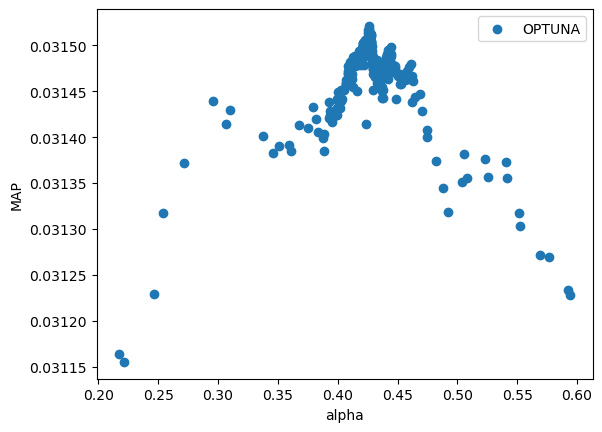

In [25]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.scatter(opt_df["params_alpha"].values, opt_df["value"].values, label="OPTUNA")
#pyplot.plot(MAP_per_shrinkage_rnd["shrink"].values, MAP_per_shrinkage_rnd["MAP"].values, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('alpha')
pyplot.legend()
pyplot.show()

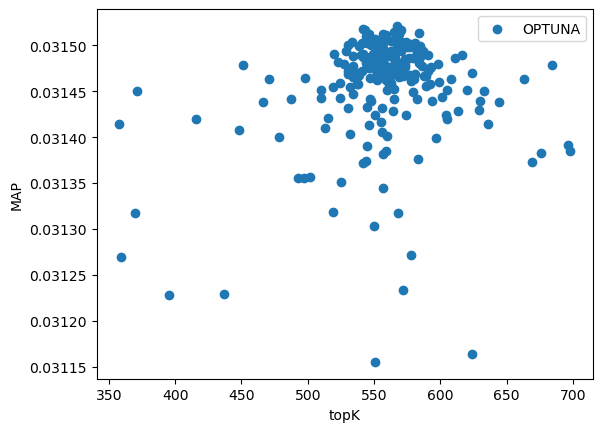

In [26]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.scatter(opt_df["params_topK"].values, opt_df["value"].values, label="OPTUNA")
#pyplot.plot(MAP_per_shrinkage_rnd["shrink"].values, MAP_per_shrinkage_rnd["MAP"].values, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('topK')
pyplot.legend()
pyplot.show()

In [15]:
study.best_params

{'topK': 574, 'alpha': 0.42549729166590694}

In [16]:
final = model(URM_train_validation)
final.fit(**study.best_params)

TypeError: __init__() missing 2 required positional arguments: 'Similarity_1' and 'Similarity_2'

In [34]:
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users=[])
evaluator_test.evaluateRecommender(slimen)

EvaluatorHoldout: Ignoring 2128 (16.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Processed 10510 (100.0%) in 7.71 sec. Users per second: 1363


(       PRECISION PRECISION_RECALL_MIN_DEN   RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                     
 10      0.096575                 0.168056  0.14239  0.049235    0.084859   
 
              MRR    NDCG        F1  HIT_RATE ARHR_ALL_HITS  ... COVERAGE_USER  \
 cutoff                                                      ...                 
 10      0.275935  0.1532  0.115091  0.529876      0.364565  ...      0.831619   
 
        COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI SHANNON_ENTROPY  \
 cutoff                                                                
 10              0.440655    0.831619       0.052188       10.152284   
 
        RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI RATIO_SHANNON_ENTROPY  \
 cutoff                                                                         
 10                       0.997715             0.149539               0.78198   
 
        RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff

In [35]:
evaluator_test.evaluateRecommender(rp3)

EvaluatorHoldout: Processed 10510 (100.0%) in 5.92 sec. Users per second: 1775


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.093482                 0.163954  0.138581  0.047853    0.083451   
 
              MRR      NDCG       F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                       ...   
 10      0.267395  0.149299  0.11165  0.514653      0.352838  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.831619          0.427995    0.831619       0.091838   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10           10.781477                   0.998471             0.263151   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                      

In [46]:
recommender = model(URM_train+URM_validation, W_slimen, W_rp3)
recommender.fit(**{'topK': 569, 'alpha': 0.42649115625702094})
#
#{'topK': 567, 'alpha': 0.42640551543098487}

ItemKNNSimilarityHybridRecommender: URM Detected 218 ( 1.7%) users with no interactions.
ItemKNNSimilarityHybridRecommender: URM Detected 110 ( 0.5%) items with no interactions.


In [47]:
evaluator_test.evaluateRecommender(recommender)

EvaluatorHoldout: Processed 10510 (100.0%) in 7.77 sec. Users per second: 1352


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.099058                 0.172739  0.145948  0.051007     0.08769   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.280128  0.157064  0.118016  0.533302      0.373221  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.831619          0.443504    0.831619       0.068198   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10           10.506646                   0.998334             0.195412   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                   

In [59]:
SLIMEN_best_params = {'topK': 7693, 'l1_ratio': 0.08013148517795793, 'alpha': 0.0012244028139782985}
RP3Beta_best_params = {'topK': 41,
 'alpha': 0.24025759098180052,
 'beta': 0.21463311953617964,
 'normalize_similarity': True}

slimen = SLIMElasticNetRecommender(URM_train=URM_all)
slimen.fit(**SLIMEN_best_params)

rp3 = RP3betaRecommender(URM_train=URM_all)
rp3.fit(**RP3Beta_best_params)

normalize_similarities = False

W_slimen = slimen.W_sparse
W_rp3 = rp3.W_sparse

SLIMElasticNetRecommender: Processed 11374 (51.2%) in 5.00 min. Items per second: 37.91
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 8.86 min. Items per second: 41.78
RP3betaRecommender: Similarity column 22222 (100.0%), 3967.67 column/sec. Elapsed time 5.60 sec


In [60]:
recommender = model(URM_all, W_slimen, W_rp3)
recommender.fit(**{'topK': 569, 'alpha': 0.42649115625702094})
#
#{'topK': 567, 'alpha': 0.42640551543098487}

In [130]:
URM_train.shape

(12638, 22222)

In [134]:
URM_train[1].nnz

22

In [142]:
URM_train[0,0]

1.0

In [144]:
recommender.recommend(0,return_scores=True)[1]

array([[      -inf, 0.00991259,       -inf, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [117]:
item_popularity_encoded = np.ediff1d(URM_all.tocsc().indptr)
item_popularity_encoded = np.sort(item_popularity_encoded)

In [62]:
target_users = pd.read_csv("Dataset/data_target_users_test.csv")
target_users.columns = ["UserID"]

In [64]:
tar_users = target_users["UserID"].astype(int)
topPop_encoded = item_popularity_encoded[-10:]

submission = []

print(np.unique(df["UserID"].values))

for index, user in enumerate(tar_users):
    if (user not in df["UserID"].values):
        item_list_encoded = topPop_encoded
    else:
        item_list_encoded = recommender.recommend(user2user_encoded[user])[:10]
    item_list = []
    for item_encoded in item_list_encoded:
        item_list.append(item_encoded2item[item_encoded])
    submission.append((user, item_list))

[    1     2     3 ... 13022 13023 13024]


In [65]:
def write_submission(submissions):
    with open("./submission_KNN_hybrid.csv", "w") as f:
        f.write("user_id,item_list\n")
        for user_id, items in submissions:
            f.write(f"{user_id},{' '.join([str(item) for item in items])}\n")
            
write_submission(submission)